In [1]:
pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [3]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("common-pile/youtube")

Resolving data files:   0%|          | 0/25 [00:00<?, ?it/s]

00022_youtube_commons.jsonl.gz:   0%|          | 0.00/323M [00:00<?, ?B/s]

00024_youtube_commons.jsonl.gz:   0%|          | 0.00/312M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/47 [00:00<?, ?it/s]

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['channel_id', 'title', 'description', 'tags', 'published_time', 'cataloged_time', 'duration', 'id', 'text', 'metadata'],
        num_rows: 1129692
    })
})

In [5]:
dataset_size = 10000
random_seed = 42

dataset_sample = ds['train'].shuffle(seed=random_seed).select(range(dataset_size))

dataset = dataset_sample.filter(lambda x: x['tags'] is not None)

dataset

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['channel_id', 'title', 'description', 'tags', 'published_time', 'cataloged_time', 'duration', 'id', 'text', 'metadata'],
    num_rows: 8597
})

In [6]:
def normalize_tag(s):
    return s.lower().replace("#", "").replace(",", "").replace(".", "").replace(" ", "")

all_tags_notna = [x for x in dataset['tags']]

all_tags = list(normalize_tag(xs) for x in all_tags_notna for xs in x)

In [7]:
import pandas as pd

pd_tags = pd.DataFrame(all_tags)

most_common_tags = pd_tags.value_counts()

most_common_tags

,count
0,
news,573
casebreak,509
sports,482
politics,391
boxbreak,346
...,...
(junctions);,1
(partc),1
(sijny),1


In [8]:
classes = list(map(lambda x: x[0], most_common_tags[most_common_tags >= 20].index.tolist()))

len(classes)

1033

In [9]:
# Класс для обработки датасета
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

class TextClassificationDataProcessor:
    def __init__(self, tokenizer_name, max_length=128, batch_size=16):
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length
        self.batch_size = batch_size

    def prepare_data(self, texts, classes, test_size=0.2, val_size=0.2, random_state=42):
        # Предполагаем, что texts - это Dataset из библиотеки datasets
        # где каждая строка имеет поля 'text' и 'tags'

        def encode_labels(example):
            label = np.argmax(np.isin(classes, example['tags'])) if np.isin(classes, example['tags']).any() else len(classes)
            return {'label': label}

        processed_texts = texts.map(encode_labels).remove_columns(['channel_id', 'title', 'description', 'tags', 'published_time', 'cataloged_time', 'duration', 'id', 'metadata'])

        # Разделяем данные на train, validation и test
        # Используем метод train_test_split из самого Dataset
        shuffled_dataset = processed_texts.shuffle(seed=42)

        # Вычисляем размеры сплитов
        test_idx = int(len(shuffled_dataset) * (1 - test_size))
        val_idx = int(len(shuffled_dataset) * (1 - test_size - val_size))

        # Создаем сплиты
        train_dataset = shuffled_dataset.select(range(0, val_idx))
        val_dataset = shuffled_dataset.select(range(val_idx, test_idx))
        test_dataset = shuffled_dataset.select(range(test_idx, len(shuffled_dataset)))

        # Создаем DatasetDict для удобства
        dataset_dict = DatasetDict({
            'train': train_dataset,
            'validation': val_dataset,
            'test': test_dataset
        })

        return dataset_dict

    def tokenize_data(self, dataset):
        def tokenize_function(examples):
            return self.tokenizer(
                examples['text'],
                padding='max_length',
                truncation=True,
                max_length=self.max_length,
                return_tensors='pt'
            )

        tokenized_dataset = dataset.map(tokenize_function, batched=True)
        tokenized_dataset.set_format(
            type='torch',
            columns=['input_ids', 'attention_mask', 'label']
        )

        return tokenized_dataset

    def create_dataloaders(self, train_dataset, val_dataset, test_dataset):
        train_dataloader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True
        )

        val_dataloader = DataLoader(
            val_dataset,
            batch_size=self.batch_size
        )

        test_dataloader = DataLoader(
            test_dataset,
            batch_size=self.batch_size
        )

        return train_dataloader, val_dataloader, test_dataloader

In [10]:
# Обучение модели BERT
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def train_bert_classifier(tokenized_datasets, num_classes, model_name="bert-base-uncased"):
    # Загружаем модель с классификационной головой
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_classes,
        problem_type="single_label_classification"
    )

    # Определяем метрики для оценки
    def compute_metrics(pred):
        softmax = torch.nn.Softmax()
        predictions = softmax(torch.tensor(pred.predictions)).numpy()
        predictions = predictions.argmax(axis=1)
        labels = pred.label_ids

        # Вычисляем метрики
        accuracy = accuracy_score(labels.flatten(), predictions.flatten())
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, predictions, average='weighted', zero_division=0
        )

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    # Аргументы для обучения
    training_args = TrainingArguments(
        output_dir='./results/bert',
        num_train_epochs=7,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        report_to="none",
    )

    # Создаем Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['validation'],
        compute_metrics=compute_metrics
    )

    # Обучаем модель
    trainer.train()

    # Оцениваем на тестовом наборе
    test_results = trainer.evaluate(tokenized_datasets['test'])

    return model, trainer, test_results

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset

# Предположим, что у нас есть датасет texts и список классов classes
# texts - Dataset из модуля datasets
# classes - список классов

# Инициализируем обработчик данных
bert_processor = TextClassificationDataProcessor(tokenizer_name="bert-base-uncased")

# Подготавливаем данные
dataset_dict = bert_processor.prepare_data(dataset, classes)

dataset_dict

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/8597 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 5158
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1719
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1720
    })
})

In [12]:
bert_tokenized = bert_processor.tokenize_data(dataset_dict)

Map:   0%|          | 0/5158 [00:00<?, ? examples/s]

Map:   0%|          | 0/1719 [00:00<?, ? examples/s]

Map:   0%|          | 0/1720 [00:00<?, ? examples/s]

In [13]:
bert_tokenized['train'] = bert_tokenized['train'].remove_columns('text')
bert_tokenized['validation'] = bert_tokenized['validation'].remove_columns('text')
bert_tokenized['test'] = bert_tokenized['test'].remove_columns('text')

In [14]:
bert_tokenized['train']['label'].type()

'torch.LongTensor'

In [15]:
import torch

torch.cuda.is_available()

True

In [16]:
# Обучаем BERT
bert_model, bert_trainer, bert_results = train_bert_classifier(
    bert_tokenized, len(classes) + 1
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,3.238500,2.993366,0.539267,0.290809,0.539267,0.377854
2,2.473600,2.448780,0.605003,0.406912,0.605003,0.472740
3,2.100500,2.235666,0.644561,0.464336,0.644561,0.530945
4,1.944500,2.219434,0.645143,0.480731,0.645143,0.544352
5,1.306500,2.282932,0.628272,0.515433,0.628272,0.556642
6,1.112200,2.312819,0.641070,0.518204,0.641070,0.562695
7,1.171600,2.343998,0.642234,0.512813,0.642234,0.563007


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [17]:
# Обучение малой LLM (DistilBERT)
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def train_small_llm_classifier(tokenized_datasets, num_classes, model_name="distilbert-base-uncased"):
    # Загружаем малую модель с классификационной головой
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_classes,
        problem_type="single_label_classification"
    )

    # Та же функция для вычисления метрик
    def compute_metrics(pred):
        softmax = torch.nn.Softmax()
        predictions = softmax(torch.tensor(pred.predictions)).numpy()
        predictions = predictions.argmax(axis=1)
        labels = pred.label_ids

        # Вычисляем метрики
        accuracy = accuracy_score(labels.flatten(), predictions.flatten())
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, predictions, average='weighted', zero_division=0
        )

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    # Аргументы для обучения
    training_args = TrainingArguments(
        output_dir='./results/small_llm',
        num_train_epochs=10,  # Может потребоваться больше эпох для малой модели
        per_device_train_batch_size=32,  # Можно увеличить размер батча для малых моделей
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        report_to="none",
    )

    # Создаем Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['validation'],
        compute_metrics=compute_metrics
    )

    # Обучаем модель
    trainer.train()

    # Оцениваем на тестовом наборе
    test_results = trainer.evaluate(tokenized_datasets['test'])

    return model, trainer, test_results


In [18]:
small_processor = TextClassificationDataProcessor(tokenizer_name="distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [19]:
# Токенизируем данные для малой модели
small_tokenized = small_processor.tokenize_data(dataset_dict)

Map:   0%|          | 0/5158 [00:00<?, ? examples/s]

Map:   0%|          | 0/1719 [00:00<?, ? examples/s]

Map:   0%|          | 0/1720 [00:00<?, ? examples/s]

In [20]:
small_tokenized['train'] = small_tokenized['train'].remove_columns('text')
small_tokenized['validation'] = small_tokenized['validation'].remove_columns('text')
small_tokenized['test'] = small_tokenized['test'].remove_columns('text')

In [21]:
small_tokenized["train"]['label']

tensor([ 194, 1033, 1033,  ..., 1033, 1033,  226])

In [22]:
# Обучаем малую LLM (DistilBERT)
small_model, small_trainer, small_results = train_small_llm_classifier(
    small_tokenized, len(classes) + 1
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,3.954700,3.624794,0.539267,0.290809,0.539267,0.377854
2,2.758900,2.863163,0.544503,0.303974,0.544503,0.386365
3,2.244500,2.498739,0.596859,0.396891,0.596859,0.467463
4,2.057200,2.246154,0.641070,0.459733,0.641070,0.529735
5,1.550800,2.313078,0.626527,0.487715,0.626527,0.543738
6,1.298700,2.411905,0.615474,0.504121,0.615474,0.548812
7,1.253400,2.504456,0.614311,0.524223,0.614311,0.558014
8,1.102900,2.576841,0.606748,0.524010,0.606748,0.556936
9,0.791200,2.573796,0.599767,0.529344,0.599767,0.557595
10,0.884000,2.590773,0.596859,0.528021,0.596859,0.556310


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Best F1 = 0.56

     Метрика      BERT  DistilBERT
0   Accuracy  0.628272    0.626527
1  Precision  0.515433    0.487715
2     Recall  0.628272    0.626527
3         F1  0.556642    0.543738


<Figure size 1000x600 with 0 Axes>

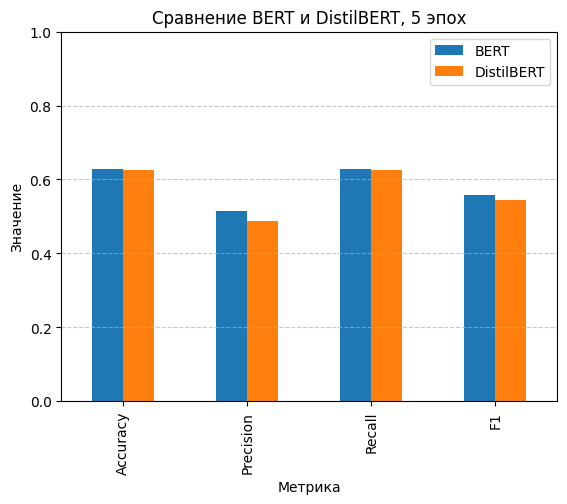

In [30]:
# Сравниваем результаты
comparison = pd.DataFrame({
    'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1'],
    'BERT': [
        0.628272, 0.515433, 0.628272, 0.556642
    ],
    'DistilBERT': [
        0.626527, 0.487715,	0.626527, 0.543738
    ]
})

print(comparison)

# Визуализируем результаты
plt.figure(figsize=(10, 6))
comparison.set_index('Метрика').plot(kind='bar')
plt.title('Сравнение BERT и DistilBERT, 5 эпох')
plt.ylabel('Значение')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('model_comparison.png')
plt.show()